<a href="https://colab.research.google.com/github/DCampos22/Movie-Recommendation/blob/main/Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎬 **Explore the AI Movie Recommendation System** 🍿

---





📚 **Imported Libraries and Modules**

Importing necessary libraries and modules for various functionalities.


In [1]:
import pandas as pd
import json
import os
import random
#import torch
import google.generativeai as genai
from IPython.display import display, HTML, Markdown
from google.colab import userdata
from typing import List
from dataclasses import dataclass
#from sentence_transformers import SentenceTransformer, util

📩 **Message Class**
Represents a message with a sender and content.

- **Attributes**:
  - `sender`: A string indicating the sender of the message.
  - `content`: A list of strings representing the content of the message.

- **Methods**:
  - `to_dict()`: Converts the message object to a dictionary format.
  - `from_dict(data)`: Constructs a message object from a dictionary.


In [2]:
class Message:
    def __init__(self, sender: str = None, content: List[str] = None):
        self.sender = sender
        self.content = content

    def to_dict(self):
        return {
            "sender": self.sender,
            "content": self.content
        }

    @classmethod
    def from_dict(cls, data):
        return cls(sender=data.get('sender'),
                   content=data.get('content'))

🤖 **AI Class**
Represents an AI system for recommending movies and engaging in conversation.

- **Attributes**:
  - `movies_df`: DataFrame containing movie data loaded from a CSV file.
  - `GOOGLE_API_KEY`: Google API key retrieved from user data.
  - `model`: Generative AI model for chat interactions.
  - `chat`: Chat instance initiated with the AI model.

- **Methods**:
  - `get_random_rows()`: Retrieves a random sample of movie data.
  - `display_random_movies(random_10_rows)`: Displays information about randomly selected movies.
  - `send_message(text)`: Sends a message to the user.
  - `genre_col()`: Classifies movie genres based on keywords in summaries.
  - `save_chat_history(messages)`: Saves the chat history to a JSON file.
  - `display_messages(messages)`: Displays conversation messages with visual styling.
  - `main()`: Main function to execute the movie recommendation system and conversation loop.


In [11]:
class AI:
    def __init__(self):
        self.movies_df = pd.read_csv('/content/archive (2) (2).zip')
        self.GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
        if self.GOOGLE_API_KEY is None:
            print("Error: API key not found. Please set the GOOGLE_API_KEY environment variable.")
            return
        genai.configure(api_key=self.GOOGLE_API_KEY)
        self.model = genai.GenerativeModel('gemini-pro')
        self.chat = self.model.start_chat(history=[])

    def get_random_rows(self):
        return self.movies_df.sample(n=20)

    def display_random_movies(self, random_10_rows):
        movie_info_list = []
        for index, row in random_10_rows.iterrows():
          if row['Genre'] != 'Unknown':
            movie_info = f"{index + 1}. Movie: {row['Title']} ({row['Year']})\nGenre: {row['Genre']}\nSummary: {row['Summary']}\n"
            movie_info_list.append(movie_info)
        return '\n'.join(movie_info_list)

    def send_message(self, text):
        print(text)

    def genre_col(self):
        # Define keywords for each genre
        action_keywords = ['action', 'adventure', 'fight', 'battle']
        romance_keywords = ['romance', 'love', 'relationship']
        comedy_keywords = ['comedy', 'funny', 'humor']
        drama_keywords = ['drama', 'emotional', 'heartfelt']
        thriller_keywords = ['thriller', 'suspense', 'mystery', 'intense']

        # Initialize 'Genre' column with 'Unknown'
        self.movies_df['Genre'] = 'Unknown'

        # Iterate through each row and update the 'Genre' column based on keywords in 'Summary'
        for index, row in self.movies_df.iterrows():
            summary = str(row['Summary']).lower()

            if any(keyword in summary for keyword in action_keywords):
                self.movies_df.at[index, 'Genre'] = 'Action'
            elif any(keyword in summary for keyword in romance_keywords):
                self.movies_df.at[index, 'Genre'] = 'Romance'
            elif any(keyword in summary for keyword in comedy_keywords):
                self.movies_df.at[index, 'Genre'] = 'Comedy'
            elif any(keyword in summary for keyword in drama_keywords):
                self.movies_df.at[index, 'Genre'] = 'Drama'
            elif any(keyword in summary for keyword in thriller_keywords):
                self.movies_df.at[index, 'Genre'] = 'Thriller'


    def save_chat_history(self, messages):
        # Initialize an empty list to store the chat history
        chat_history_json = []

        # Iterate over each message in the chat history
        for message in messages:
            # Create a dictionary representing the message
            message_dict = {
                "role": message["role"],
                "text": message["parts"][0]
            }
            # Append the message dictionary to the chat history list
            chat_history_json.append(message_dict)

        # Convert the chat history list to JSON format
        chat_history_json_str = json.dumps(chat_history_json)

        # Write the JSON string to a file
        with open('chat_history.json', 'w') as f:
            f.write(chat_history_json_str)

        # Download the file
        from google.colab import files
        files.download('chat_history.json')

    # Function to display conversation messages with visual styling
    def display_messages(self, messages):
        bubble_style = """
        <style>
            .message {
                max-width: 60%;
                margin: 5px;
                padding: 10px;
                border-radius: 20px;
            }
            .sender {
                background-color: #007aff;
                color: white;
                margin-left: auto;
                margin-right: 0;
            }
            .receiver {
                background-color: #e5e5ea;
                color: black;
                margin-left: 0;
                margin-right: auto;
            }
        </style>
        """

        html_str = "<div>"

        for msg in messages:
            content = msg["parts"][0]["text"].replace('**', '')
            if msg["role"] == "user":
                bubble_class = "sender"
            else:
                bubble_class = "receiver"

            html_str += f'<div class="message {bubble_class}">{content}</div>'

        html_str += "</div>"
        html_str += bubble_style

        display(HTML(html_str))



    def main(self):
        self.genre_col()
        random_10_rows = self.get_random_rows()
        data = self.display_random_movies(random_10_rows)
        print(data)

        # Initial system instructions
        system_instructions = f"""
        Please help me in recommending movies.
        Those are the movies we know about

        {data}

        Critical instructions:
        - Considering the themes, genres, and narratives of the movies listed above, please recommend movies that share similar qualities, you can only recommend movies that are in the above list.
        - While recommending movies, make sure to be brief and to ask further questions to give the best recommendations

        """

        # Model to greets the user to start conversation
        model_message = {'role': 'assistant', 'parts': [{'text': "Hello, I recommend movies from the list above, how can I help you?"}]}
        self.display_messages([model_message])

        while True:
          messages = []



          # Get user input
          user_input = input("User: ")

          # Prepare user message for display
          user_message = {'role': 'user', 'parts': [{'text': user_input}]}
          # Add user message to messages list for the model
          messages.append({'role': 'user', 'parts': [{'text': system_instructions}, {'text': user_input}]})


          # Display user message
          self.display_messages([user_message])

          # Check if the user wants to end the conversation
          if user_input.lower() == 'thanks, bye':
              farewell_message = {'role': 'assistant', 'parts': [{'text': "Thank you for using our movie recommendation system. Have a great day!"}]}
              self.display_messages([farewell_message])
              break

          # Generate model response
          response = self.model.generate_content(messages)

          # Check if the response is valid and contains parts
          if response and hasattr(response, 'parts') and response.parts:
              response_text = response.parts[0].text  # properly accessing the text attribute of the first Part object
              model_message = {'role': 'assistant', 'parts': [{'text': response_text}]}
              # Display model response
              self.display_messages([model_message])
          else:
              print("Error: Model response is empty, invalid, or blocked. Please check safety ratings if available.")
              if hasattr(response, 'candidate') and hasattr(response.candidate, 'safety_ratings'):
                  print("Safety Ratings:", response.candidate.safety_ratings)
              continue  # Skip to the next iteration of the loop

          # Optionally save each pair of user and assistant messages if needed
          self.save_chat_history(messages)


🚀 **Script Entry Point**
Entry point of the script to execute the movie recommendation system.

- **Functionality**:
  - Creates an instance of the `AI` class.
  - Calls the `main()` method of the `AI` instance to start the movie recommendation system and conversation loop.


In [12]:
if __name__ == "__main__":
    ai = AI()
    ai.main()


2015. Movie: Loosies (2011)
Genre: Action
Summary: A young pickpocket in the New York subways, living a fast, free, lifestyle is confronted by a woman whom he had a one night affair with, she informs him that she is now pregnant with his child, he must now choose between continuing the lifestyle he lead or take responsibility for his actions.

2043. Movie: Legally Blonde (2001)
Genre: Action
Summary: Elle Woods (Reese Witherspoon) has it all. She's the president of her sorority, a Hawaiian Tropic girl, Miss June in her campus calendar, and, above all, a natural blonde. She dates the cutest fraternity boy on campus and wants nothing more than to be Mrs. Warner Huntington III. But, there's just one thing stopping Warner (Matthew Davis) from popping the question: Elle is too blonde. Growing up across the street from Aaron Spelling might mean something in LA, but nothing to Warner's East-Coast blue blood family. So, when Warner packs up for Harvard Law and reunites with an old sweetheart f

User: Do you recommend any romance films?


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

User: I am also interested in action films


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

User: thanks, bye


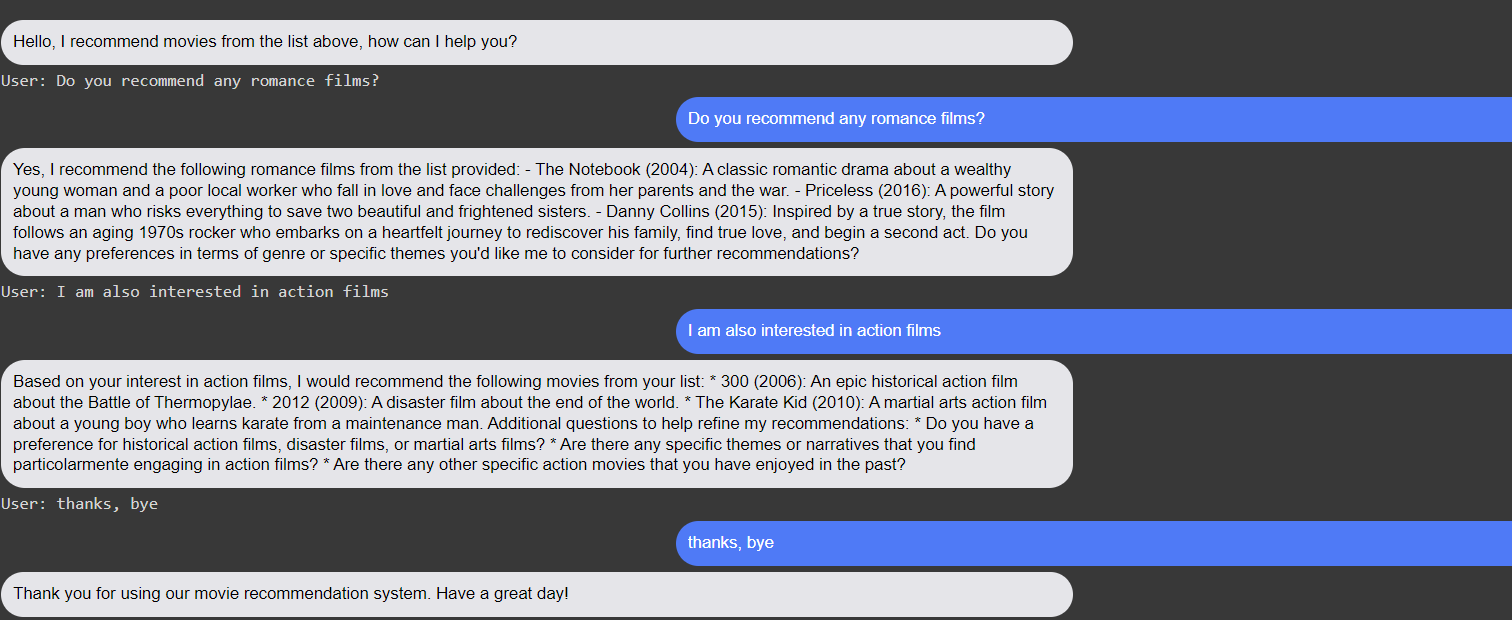